# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**
- *The Smartcab does not move at all during the simulation.*
- *Positve and Negative rewards are observed during the simulation.*
- *Given Smartcab idles forever, there are now three types of situations:*
    - *case 1: red light: positive reward.*
    - *case 2: green light without oncoming traffic: negative reward. (abs value larger than the red light case)*
    - *case 3: green light with oncoming traffic: positive reward (smaller than red light case) for most of the time, sometimes similar reward to case 2.*

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

*Explain 3 flags:*
- *enforce_deadline: if set to True, it will affects 2 parts:* 
    - *Trail termination (and successfulness status) will depend on number steps to deadline, not on a hard-coded number of update steps.*
    - *Number of steps to deadline will be considered part of reward.*
- *update_delay: it controls the time interval between two updates in simulation, the smaller delay, the faster the simulation will proceed.*
- *tolerance: it is the trigger condition (when epsilon, probability for random search has decayed below this tolerance value) to start the testing trials in 'learning' mode, where primary agent's policy is supposed to be fixed.*

*An actual action for a specific agent is performed in env.act(), which is called inside agent.update(). Performing an action actually consists of two parts, determine which action to take based on current state and take the action, that is what the update() function does. At higher level, all agents update() function is called inside env.step().*

*They both provide verbose information of the simulation status, but at different places:*
- *render_text() prints information in console.*
- *render() prints information on pygame GUI.*

*next_waypoint() checks dx first, i.e. East-West first.*

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


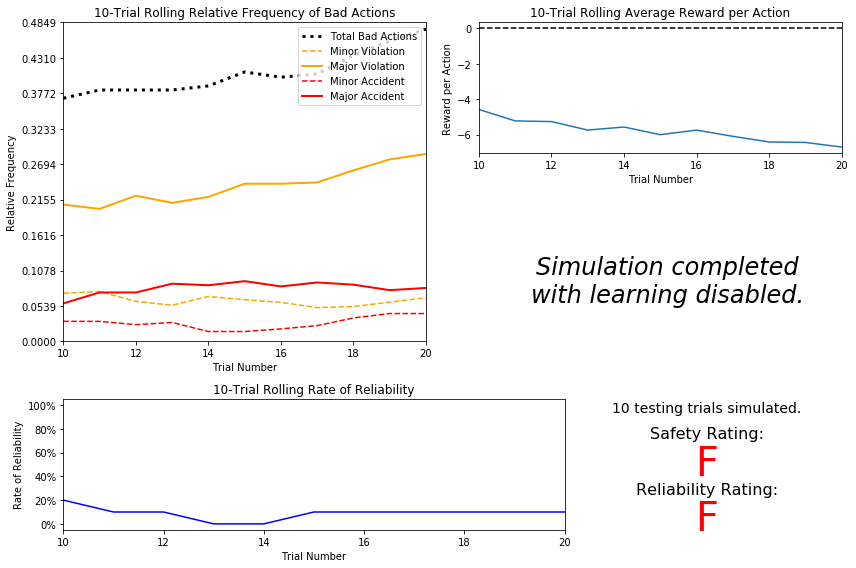

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

- *On average, 40% of the time the driving agent makes bad decisions, around 1/4 of them are accidents. I actually have run this simulation several times, and interestingly, Major Violation rate is significantly higher than Minor Voilation rate. Verified in code (the def of major violation and minor violation), indeed Major Violation is more prone to happen by nature.*
    - *Minor Violation: action is None & light is Green & have oncoming car & oncoming car is not taking a left turn.*
    - *Major Violation: *
        - *action is forward & light is red & not (have left car & left car goes forward OR have right car & right car goes forward)*
        - *action is left & light is red & not (have oncoming car & oncoming car turns right OR have left car & left car goes forward OR have right car & right car goes forward)*
- *Rate of reliability is low, sometimes around 20%, sometimes all zero, looks 20% is the upper bound here. Since allowed number of moves is 5 times of distance, I'm just curious if there is some relationship between this 5 multiplication and 20% here. But just to say that for most of the time, the primary agent cannot reach destination within deadline, I think it is reasonable because the car is just moving randomly.*
- *The reward is always negative, at around -5. Considering valid moves give positive reward, I think it is OK to say it has been heavily penalized.*
- *As number of trials increases, the outcome does not change significantly, which makes perfect sense, as the agent is not accumulating any knowledge, every trial is independent of each other.*
- *Of course this 'Smartcab' is not safe or reliable, simply speaking, both the Safely Rating and Reliability Rating are F.*

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

*All the them are relevant:*
- *inputs are relevant for safety:*
    - *light: e.g. going forward at red light would be at least a major violation.*
    - *oncoming: e.g. turning left on a green light while an oncoming car is turning right would be a minor accident.*
    - *left: e.g. turning left on a red light with a left car going forward would be a major accident.*
    - *right: e.g. going forward on a red light with a right car going forward would be a major accident*

- *waypoint and deadline are relevant for efficiency:* 
    - *Deadline tells how much time we got left, to reach destination within deadline, with proper setup of rewards, there might exist cases when some safety could be sacrificed.* 
    - *Waypoint indicates relationship between current location and destination. While achieving safety, agents should try to get to destination as quickly as possible.*

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

*Based on reasoning in Question 4, total number of possible states is: 3 (waypoint is suggesting {forward, right, left}) by 2 (light could be {green, red}) by 4 (oncoming car could be {None, forward, right, left}) by 4 (left car could be {None, forward, right, left}) by 4 (right car could be {None, forward, right, left}) by n (max possible number of steps to deadline) = 384n*

*Current simulation setup can not train all this number of states. Ignoring the n part, we do 20 trails (assuming 1/t espilon decay and default tolerance as 0.05), each trial with number of steps as 5 times initial distance, which is at least 4, at most 7. So For simplicity, let's say on average the distance is 6, so that would be 600 single steps in total, which gives less than 2 for each state on average. If deadline is considered, for each deadline, at most 20 trails is possible, so it is 20 experiments on 384 states.*

*It is for sure not to include deadline, but it is possible to adjust epsilon decay schedule to have more training trials. Allowing 20 samples for each state would be 256 (20 by 384 / 30) trials. I am not sure whether it is enough to get a good training for all states, but the time consumption is practical as 20 trials + 10 tests takes 8 seconds, so 256 trials + 10 tests would still be a little bit more than 1 minute.*

*So, I would propose 2 candidate plans (number of trials chosen depends on actual experiment results):*
- *Plan 1: train on 3 (waypoints) by 2 (light) by 2^3 (for oncoming & right & left, only consider 2 states of existing or not) = 48 states.*
- *Plan 2: train on 384 states as stated above, ignoring deadline.*

*With given reward setup, I doubt the extent to which penalty from time-remaining helps with learning efficiency. Penalty from time-remaining for each step at most (standing at deadline) is 1, while a bad action's penalty is at least 5. Although reward difference between correct & valid action and incorrection & valid action is 1, I see no point sacrificing reward of 1 going in the incorrect direction would get to destination faster. Moreover, there is no additional penalty for failing to get to desination in time. So I think with current setup, all that relates to reliability is moving in the planner-suggested way point. So, to achieve better reliability, I think it all relies on the 'next-waypoint' state attribute, i.e. learn to act as the planner suggested while not breaking the rules.*

*Comparatively, if both trained with sufficient trials, I expect plan 2 will perform better in terms of reliability. As plan 1 has some uncertainty with its state information. Only knowing the existence of cars in each direction is not sufficient to make the best decision, so the optimal policy should consider the worst possible case to avoid violation, which will introduce more conflicts to planner suggested move.*

*From Q6, only 20 trails are used, plan 2 is not practical, so I go with plan 1. To be comparable plan 1 is also used for Q7, but resutls for plan 2 will also be demonstrated.*

*Three points I would like to argue w.r.t. review of my first submission:*
- *I wouldn't quite agree that plan 1 is a knowledge-based approach. There is always a trade off between completeness of information usage and computing resources. Here, I would say plan 1 is one of the experiments, I used a systemically simplified state definition, so that it requires less trials for sufficient training, to see if it is sufficient to meet the final goal, i.e. achieving a satisfactory safety rating and reliability rating. If it can, why not do the same with less resources, but if it cannot, then we try using more information, then model iterates until we achieve the goal. As reviwer mentioned, in a real world problem, dimension to define a state could be very high, if facing a situation of lack of data (e.g. a financial trading problem), some heuristic simplification of state info has to be conducted for the training to make sense. At least it worth a try to find out whether a simplied def can help make use of the not-sufficient data can achieve the ultimate goal.*
- *I don't think including deadline will shift goals to breaking rules to meet deadline. As mentioned above, current reward / penalty setup does no encourage at all for breaking rules to meet deadline, even with deadline included as part of state. So my point of view, is that, including deadline in state increases problem dimension with no benefit, yet not negative impact either. And in a more general problem setting, deadline is relevent for safety and reliability training, depending on the ultimate goal, and corresponding reward schedule.*
- *Why at least one visit for each state is sufficient for a good training, because of the reward and learning rate setup? I suppose sufficient number of visiting to one state is needed for a good learning of its Q value.*

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

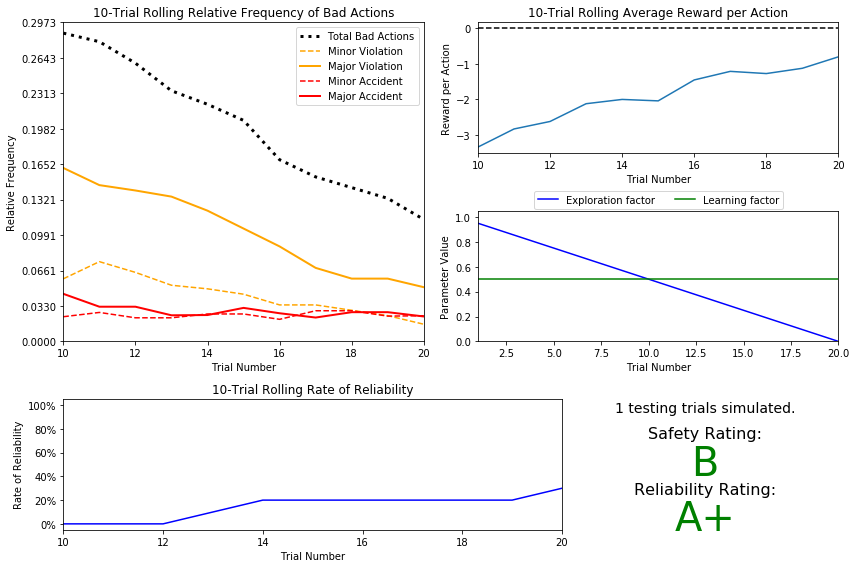

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**
- *Quick walking through some of the questions from Q3:*
    - *Bad action rate goes from over 20% to below 13% along training, overall accidents rate also has a down trend, but not obvious. On average, the rate is 3% - 4%.*
    - *Reliability look lower than I expected. As I mentioned in Q5, training of reliability should all depends on the 'next-waypoint' state attribute, which should be able to be learned.*
    - *The rewards is still negative, but also sign of learning is obvious, and it gets close to 0 at the end of training.*
    - *Yes, learning is effective, results gets better along training.*
    - *surprisingly safety rating is B and reliability rating is A+. Given the training resutls, I would say it is pure luck due to insufficient testing trials. So even with good looking testing rating, I wouldn't say this smartcab is good enough now.*
- *With default Q-learning schedule, we can see learning is effective, just number of trials is too small for all states to get enough experience.*
- *Nothing looks similar between default Q-learning and basic version:*
    - *Bad action rate does gets lower along training, the downward trend can be more or less obviously observed in all categories. And the values are much lower than that of the random version.*
    - *Reliability rate's upward trend is not obvious, but it is OK to say that there is no obvious sign of random move. And the average success rate is much higher than that of the random version.*
    - *In the reward graph, reward is going up along time, showing effectiveness of learning. And the reward of first 10 trials is higher than that of the random version.*
    - *Now safety rating is still below requirement (but above expectation), and reliability rating looks perfect. As mentioned above, given training results, and lack of testing trails, they are not trustable.*
- *From the Trial-number vs. Parameter value graph, 20 trials of training is used before testing, which is exactly what the epsilon schedule enforces: it takes 20 steps to decay from 1 to the first value below tolerance = 0.05, which is actually 0.*
- *Yes, the exploration factor is in the param panel, whcih decays from 1 to 0 in the 20 trials.*
- *As the number of training trials increases, number of bad actions increases and average reward increases.*

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

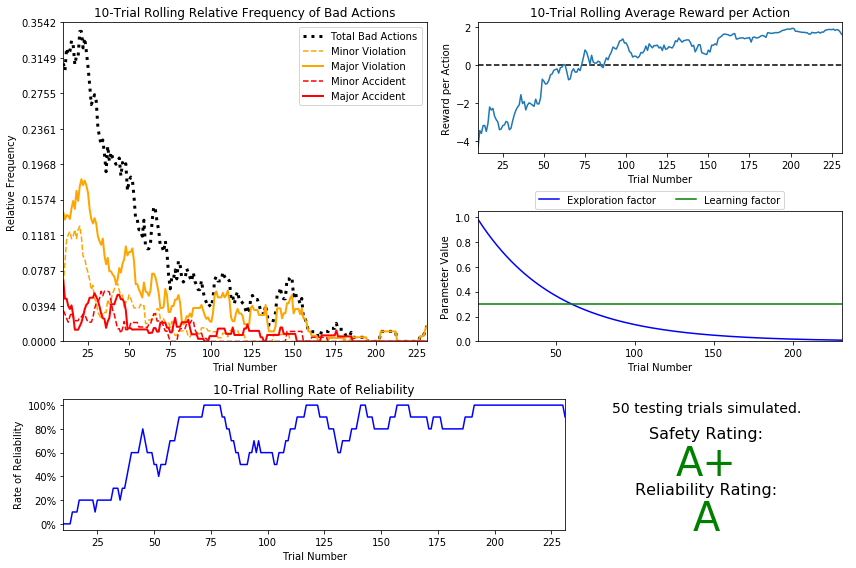

In [6]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_simpleState.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

- *50 trials are used for testing for more statistically robust results.*
- *I used the functional form of epsilon = exp(-0.02t), with 2 considerations:*
    - *first, this form is chosen with the thought to use less time when training with more randomness. As the training gets finer, i.e. with less randomness, we are in the stage of searching for the (local) minimuum, thus, need to run it with more times to get a more accurate value.*
    - *0.02 is chosen so that, together with tolerance choice, I want to make sure enough number of trials are taken (I preferred 200+ trails which averages to 100+ experiments for each state).*
- *Together with a tolerance of 0.01, it takes around 230 trials before beginning testing.*
- *Actually I first decided 0.01 for tolerance, then finding 0.02 correspondingly for epsilon decay, I made this choise with the feel that default value of 0.05 is a bit too high for the purpose of local optimization. I choose alpha as 0.3, feeling 0.5 is a bit aggressive to pick up new experiences.*
- *Improvement is significant.*
    - *Bad action rate effectively gets reduced to 0 in training, and get A+ in testing.*
    - *Reliability rate also gets significantly improved: 80% to 100% in training, and get A in testing.*
    - *Reward gets improved to very close to 2, which is the most an action can get.*
- *Yes, I think it is OK to say the learned policy is appropriate.*
- *Yes I am satisfied with the final ratings for both safety and reliability. As mentioned in Q5, the penalty setup puts safety beyond reliability, i.e. system will not encourage to sacrifice safety for reliability. So, getting A+ in safety is exactly what the system requires. Actually getting an A in reliability has already got some luck. With current setup, the cab tends to comply with rules, in a bad luck case, e.g. always red lights, not being able to reaching desination in time is a reasonable result. As in the usual case, when we take a human-driver cab, being late for a flight is preferred than risking having an accident.*

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

*The Rule of Thumb is to comply with what planner suggests when there is no breaking of rule, otherwise comply with the rule. With simple state def, algo cannot learn the optimal action in some cases, due to missing information.*

*I would like to give 2 sets of examples:*

*states that gives optimal action:*

- *Complying with planner's suggestion when there is no breaking of rule.*
    - *state = (next_way_point = right, light = red, oncoming is None = True, left is None = True, right is None= True).*
    - *forward: -9.45*
    - *right: 1.60*
    - *None: 1.29*
    - *left: -10.20*
    - *Policy suggests going right as next_way_point. With red light, left car going forward would cause an accident if we turn right. Yet there is no car on the left, so safe to turn. And interestingly to note, reward of staying still is very close to policy action, as it makes no violation (positive reward), but not optimal (wastes time).*

- *Reject planner's suggestion when there is risk to break the rule.*
    - *state = (next_way_point = right, light = red, oncoming is None = True, left is None = False, right is None = True)*
    - *forward: -24.05*
    - *right: -6.36*
    - *None: 2.17*
    - *left: -11.84*
    - *This is the counter case of above example. With red light, existance of left car makes the potential danger that it may go forward if we turn right. So to avoid this possibility, policy suggests that we should stay still for the moment. Be noted stay still in red light receives the same reward as following next-waypoint in green light.*
    
*states that do not always give optimal action (as reviewer suggested). Actually, without full-state information, we do not know what the optimal action is, but there is probability it is not taking the optimal action, if given all details.*

- *case 1:*
    - *state = (next_way_point = left, light = green, oncoming is None = False, left is None = False, right is None= False).*
    - *forward: 0.00*
    - *right: 0.96*
    - *None: -1.68*
    - *left: 0.00*
    - *With green light, and cars in all directions:*
        - *turning left could have accident if oncoming car goes right or forward. But Q for left action is 0, which means, by chance, during training, above case does not happen, which suggests chosen number of trails was not enough for simple-state.*
        - *going forward or turning right would be bad-action-clear, but penalized by not following waypoint. Among the two, randomness suggests right.*
        - *Stay still would be a minor violation, as reflected in reward.*
    - *But if the oncoming car goes left, following the next-waypoint is a valid move, making algo suggested action sub-optimal.*

- *case 2:*
    - *state = (next_way_point = left, light = green, oncoming is None = False, left is None = True, right is None= False).*
    - *forward: 0.88*
    - *right: 0.30*
    - *None: 0.35*
    - *left: -10.48*
    - *with green light, no car on the left, but cars in front and on the right*
        - *same as above, turning left while oncoming cars going right or forward would cause an accident, and we do see this in training here.*
        - *same as above, going froward and going right are equally sub-optiamlly good, randomness chooses forward.*
        - *None would cause a minor violation if oncoming is not turning left, but sub-optimal otherwise. Positive Q here again shows that action = None + oncoming going right or forward combinations do not appear in training*
    - *Same as above, if oncoming car goes left, algo suggested move is sub-optimal.*

*Two things to note here:*
- *compared to full state, simple-state not only causes less prob to reach destination in time, but also more sub-optimal actions leads to lower rewards.*
- *to consider sufficiency of trials in Q-learning, need to consider dim of state times dim of actions.*



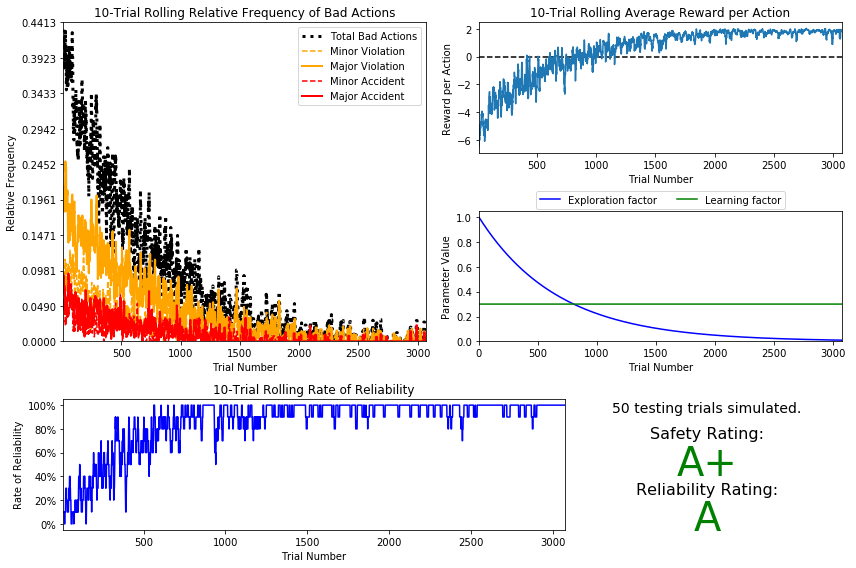

In [7]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_fullState.csv')

*Full State (plan 2 from Q5) is run with epsilon decaying factor of 0.0015, so that with 16 times more states, we run about 16 times of trials (it is actually still a bit short of trials with this setup).*
- *We still get A+ in safety testing, although bad-action rate does not fully converge to 0 in training.* 
- *But as expected, reliability behavior in training is better than plan 1, although testing rating is the same. As mentioned above, although it is better, we cannot ensure an A+ in testing, luck plays a role there.*
- *Also, reward converges to a higher level that with simple-state.*

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

- *The Smartcab related point is, the Smartcab treats all rewards equally, getting an accident later is no better than having one now. Since gamma has to be smaller than 1 to make it work, future rewards in only valid when early reward is better than later reward. Without this underlying logic, train as if so is not logically consistent.*
- *The env related point is state definition and rewards associated to it. Defining distance of current location to destination as the planner suggested move puts all rewards into action, there is no reward related to state itself. Since which state it falls into has nothing to do with reward, learning the optimal policy should not rely on that.*
- *Discounting future rewards not only does not help, it actually gets things worse. As the future reward term is only an approximation of expected value of next state's Q value. Including it in learning would introduce more randomness, making the learning slower.*

*Updated comments below, according to review of submit-1. Actually I don't feel the reviewer's comment helps:*
- *I don't think agent need to 'see' the next state to make future reward useful. If future reward is to be used, I think the way to do it is to stand in s_prime then look back and update for (s, a), not standing at s and look ahead what s_prime could be.*
- *env's deterministicness should not be the reason for considering future reward or not. Most of real problem does not have deterministic env. Like in finance world, randomness in env has little to do with action chosen by agent, I don't think it means future reward should not be considered for RL.*
- *Actually I believe the only reason for future Q irrelevant in this problem is that all that matters for reward are associated to action, nothing to state, so knowing from next state does not help with learning, but only introduces randomeness and reduces learning efficiency. Having to split this point into 2 parts of smartcab related and env related made me a bit unconfortable.*

*Updates according to review of submit-2:*

*Now I see the point. My previous thought was wrong: even if there is reward associated to state, it still does not work. The problem is that, future state (s_prime) does not depend on (s, a) at all, T(s, a, s_prime) is essentially Prob(s_prime). So the (expected) future term would be the same for all (s, a), including it does not help at all, but introduce meaningless randomness. And this property is causes by two conditions, either one solved would make future relavent. As reviwer suggested:*
- *The cab itself cannot see into the future, if the car can know its relative position to destination as a state (like having an GPS), then next state is relavent to (s, a).*
- *The env (start point and destination) gets re-initialized each trial, even (s, a) -> s_prime mapping exists within one trial, if it changes every trial, the 'learned' distribution from previous trial is actually misleading, because globally, there is no stationary mapping.*

*One more comment to add is that, this setup is more of a supervised learning problem: predict immediate reward from (s, a) observation, and instead of a functional form, it learns a descrete mapping from (s, a) to reward by averaging all observed rewards for each (s, a), exactly as in course video where explaining why alpha is used.*


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.